In [1]:
import numpy as np
from lensing_data_class import LensingData
from cluster_local_tidy import ClusterLensing
import os
import matplotlib.pyplot as plt
from astropy.io import fits
from astropy.cosmology import FlatLambdaCDM
from cluster_local_new import ClusterLensing_fyp
import pandas as pd
import corner
import arviz as az
import pathlib

In [2]:
import warnings

# Suppressing the lenstronomy warning on astropy.cosmology
from lenstronomy.LensModel.lens_model import LensModel
warnings.filterwarnings("ignore", category=UserWarning, module='lenstronomy.LensModel.lens_model')

In [7]:


# --- 1. Create Dummy Lensing Data ---
# In a real scenario, you would load your FITS files or other data here.
# We'll create placeholder data for 2 clusters.
# The maps are small for this example (e.g., 200x200 pixels).

scenarios = {
        '1': 'abell370',
        '2': 'abell2744',
        '3': 'abells1063',
        '4': 'macs0416',
        '5': 'macs0717',
        '6': 'macs1149'
    }

full_cluster_names = {
        'abell370': 'Abell 370',
        'abell2744': 'Abell 2744',
        'abells1063': 'Abell S1063',
        'macs0416': 'MACS J0416.1-2403',
        'macs0717': 'MACS J0717.5+3745',
        'macs1149': 'MACS J1149.5+2223'
    }

# Initialize lists to store the data arrays
datax_list = []
datay_list = []
data_psi_list = []

for i in scenarios:
    clustername = scenarios[i]
    full_cluster_name = full_cluster_names[clustername]

    file_dir = os.getcwd()
    fits_filex = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/diego/hlsp_frontier_model_{clustername}_diego_v4.1_x-arcsec-deflect.fits'
    )
    fits_filey = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/diego/hlsp_frontier_model_{clustername}_diego_v4.1_y-arcsec-deflect.fits'
    )
    psi_file = os.path.join(
        file_dir,
        f'GCdata/{full_cluster_name}/diego/hlsp_frontier_model_{clustername}_diego_v4.1_psi.fits'
    )

    with fits.open(fits_filex) as hdulx, fits.open(fits_filey) as hduly, fits.open(psi_file) as hdul_psi:
        datax = hdulx[0].data
        datay = hduly[0].data
        data_psi = hdul_psi[0].data

        # Append the data arrays to the lists
        datax_list.append(datax)
        datay_list.append(datay)
        data_psi_list.append(data_psi)

# getting the pixel scale list
pixscale_list = [0.42, 0.51, 0.51, 0.42, 0.42, 0.42]
lensing_data = LensingData(
    alpha_maps_x=datax_list,
    alpha_maps_y=datay_list,
    lens_potential_maps=data_psi_list,
    pixscale = pixscale_list,
    z_l_list = [0.375, 0.308, 0.351, 0.397, 0.545, 0.543], # Lens redshifts for the two clusters
    # We can use the default x_center, y_center, and search_window_list
    # or override them if needed.
)

# --- 2. Define the "True" Observed Data ---
# This is the data you are trying to fit. For a strongly lensed supernova,
# this would be the measured time delays between the images.
# Let's assume a 4-image system.
dt_true = np.array([   0.        , 4722.09151606, 5726.87137736, 6178.592956  ,
       6376.37992613, 6552.76725006]) # First image is reference (delay=0)

# --- 3. Initialize the Main Analysis Class ---
# z_s_ref is a reference source redshift used for initial scaling calculations.
# It can be an estimate of the source's redshift.
z_s_ref = 1.5 
cluster_system = ClusterLensing(data=lensing_data, z_s_ref=z_s_ref)

print("Setup complete. Lensing system initialized.")

Setup complete. Lensing system initialized.


In [9]:
# test image pos and dt
test_params = {"x_src" : 80.5, "y_src": 74.0, "z_s": 3.2, "H0": 70.0}
test_cluster = 0
# Calculate the image positions and time delays for the test parameters
output = cluster_system.calculate_images_and_delays(
    test_params, test_cluster
)
print(output['time_delays'])


[0.]


In [11]:
# test chi sq calculation
test_params_chi_sq = {
    "x_src": 80.5, 
    "y_src": 74.0, 
    "z_s": 3.2, 
    "H0": 70.0
}
chi_sq_value = cluster_system._calculate_chi_squared(
    params=test_params_chi_sq,
    dt_true=dt_true,
    index=test_cluster,
    sigma_dt=0.05 # Assumed fractional error on time delays
)

print(f"Chi-Square value for the test parameters: {chi_sq_value}")

# Example with a bad parameter set that produces a different number of images
bad_params = {"x_src": 9.0, "y_src": 10.0} # Likely to produce 0 or 1 image
chi_sq_penalty = cluster_system._calculate_chi_squared(
    params=bad_params, dt_true=dt_true, index=test_cluster
)
print(f"Chi-Square penalty for a bad parameter set: {chi_sq_penalty}")

Chi-Square value for the test parameters: 6708.203932499369
Chi-Square penalty for a bad parameter set: 7348.469228349533


In [ ]:
# test only de
# --- Running the DE Optimization ---
# The goal is to find which cluster model (0 or 1) and which source position
# best reproduce the observed time delays dt_true.

print("\n--- Running Differential Evolution (DE) to find the best fit ---")

# Optional: DE settings can be customized. Using defaults here.
# de_settings = {'popsize': 50, 'maxiter': 300, 'disp': False}
best_result_de = cluster_system.find_best_fit(
    dt_true=dt_true,
    run_mcmc=False, # We are NOT running MCMC yet
    # de_settings=de_settings 
)

print("\n--- DE Optimization Complete ---")
print(f"Best cluster index: {best_result_de['cluster_index']}")
print(f"Minimum Chi-Square: {best_result_de['chi_sq']:.3f}")
print("Best-fit parameters:")
for param, value in best_result_de['params'].items():
    print(f"  {param}: {value:.4f}")

In [6]:
# test de then mcmc 
print("\nRunning the full analysis pipeline...")

cosmos = FlatLambdaCDM(H0=test_params['H0'], Om0=0.3)
lum_dist_true = cosmos.luminosity_distance(test_params['z_s']).value  # Luminosity distance in Mpc
print("True luminosity distances:", lum_dist_true)

# Define settings for the MCMC sampler
mcmc_settings = {
    "n_walkers": 20,      # Number of MCMC walkers
    "n_steps": 8000,      # Number of steps per walker
    "fit_z": True,        # We want to fit for the source redshift (z_s)
    "fit_hubble": True,   # We want to fit for the Hubble constant (H0)
    "lum_dist_true": lum_dist_true, # An external "true" luminosity distance measurement (in Mpc)
    "sigma_lum": 0.05,     # The fractional error on the luminosity distance
    # Define the prior boundaries for the parameters being fit in the MCMC
    "z_bounds": (1.0, 5.0),
    "H0_bounds": (60, 80)
}

# Call the main analysis function
# The function will first run DE to find the best cluster,
# then run MCMC on that best-fit model.
mcmc_results, accepted_cluster_indices = cluster_system.find_best_fit(
    dt_true=dt_true,
    run_mcmc=True,
    mcmc_settings=mcmc_settings
)
print(f"\nAnalysis complete. Found {len(mcmc_results)} cluster(s) meeting the MCMC criterion.")



Running the full analysis pipeline...
True luminosity distances: 27472.242736711658
--- Running DE for Cluster 0 ---
differential_evolution step 1: f(x)= 64.43010419931264
differential_evolution step 2: f(x)= 64.43010419931264
differential_evolution step 3: f(x)= 64.43010419931264
differential_evolution step 4: f(x)= 64.43010419931264
differential_evolution step 5: f(x)= 64.43010419931264
differential_evolution step 6: f(x)= 64.43010419931264
differential_evolution step 7: f(x)= 64.43010419931264
differential_evolution step 8: f(x)= 39.613805004182254
differential_evolution step 9: f(x)= 39.613805004182254
differential_evolution step 10: f(x)= 39.613805004182254
differential_evolution step 11: f(x)= 39.613805004182254
differential_evolution step 12: f(x)= 39.613805004182254
differential_evolution step 13: f(x)= 39.613805004182254
differential_evolution step 14: f(x)= 39.613805004182254
differential_evolution step 15: f(x)= 27.962771462252363
differential_evolution step 16: f(x)= 27.96

100%|██████████| 8000/8000 [6:31:39<00:00,  2.94s/it]  


Analysis complete. Found 1 cluster(s) meeting the MCMC criterion.


In [7]:
OUT_DIR      = pathlib.Path("/home/dices/Research/GWlensing_Brian/oddratio/test_tidy_1")
OUT_DIR.mkdir(exist_ok=True)

for result in mcmc_results:
        cluster_idx = result['cluster_index']
        print(f"\n--- Processing Final Results for Cluster {cluster_idx} ---")
        
        # --- Step 5: Analyze and Display ---
        sampler = result['mcmc_sampler']
        burn_in_steps = 800
        labels = list(result['params'].keys())
        flat_samples = sampler.get_chain(discard=burn_in_steps, thin=15, flat=True)
        
        print(f"--- MCMC Parameter Constraints for Cluster {cluster_idx} ---")
        for i in range(len(labels)):
            mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
            q = np.diff(mcmc)
            print(f"{labels[i]:>7s} = {mcmc[1]:.3f} +{q[1]:.3f} / -{q[0]:.3f}")

        # --- Step 6: Save the Localization Results ---
        print(f"Saving localization results for Cluster {cluster_idx}...")
        file_path = os.path.join(OUT_DIR, f"cluster_{cluster_idx}_posterior.npz")
        
        cluster_system.save_mcmc_results(
            sampler=sampler,
            best_result=result, # Pass the individual result dictionary
            n_burn_in=burn_in_steps,
            output_path=file_path,
            dt_true=dt_true,
            mcmc_settings=mcmc_settings
        )

print("\nAll processing finished.")

NameError: name 'mcmc_results' is not defined

Loading data from /home/dices/Research/GWlensing_Brian/oddratio/test_tidy_1/cluster_0_posterior.npz...
Available data keys: ['chain', 'flat_chain', 'log_prob', 'median_params', 'param_labels', 'chi_sq_for_median']

Generating corner plot...
-> Corner plot saved to /home/dices/Research/GWlensing_Brian/oddratio/test_tidy_1/cluster_0_corner_from_saved.png

Generating trace plot...
-> Trace plot saved to /home/dices/Research/GWlensing_Brian/oddratio/test_tidy_1/cluster_0_trace.png


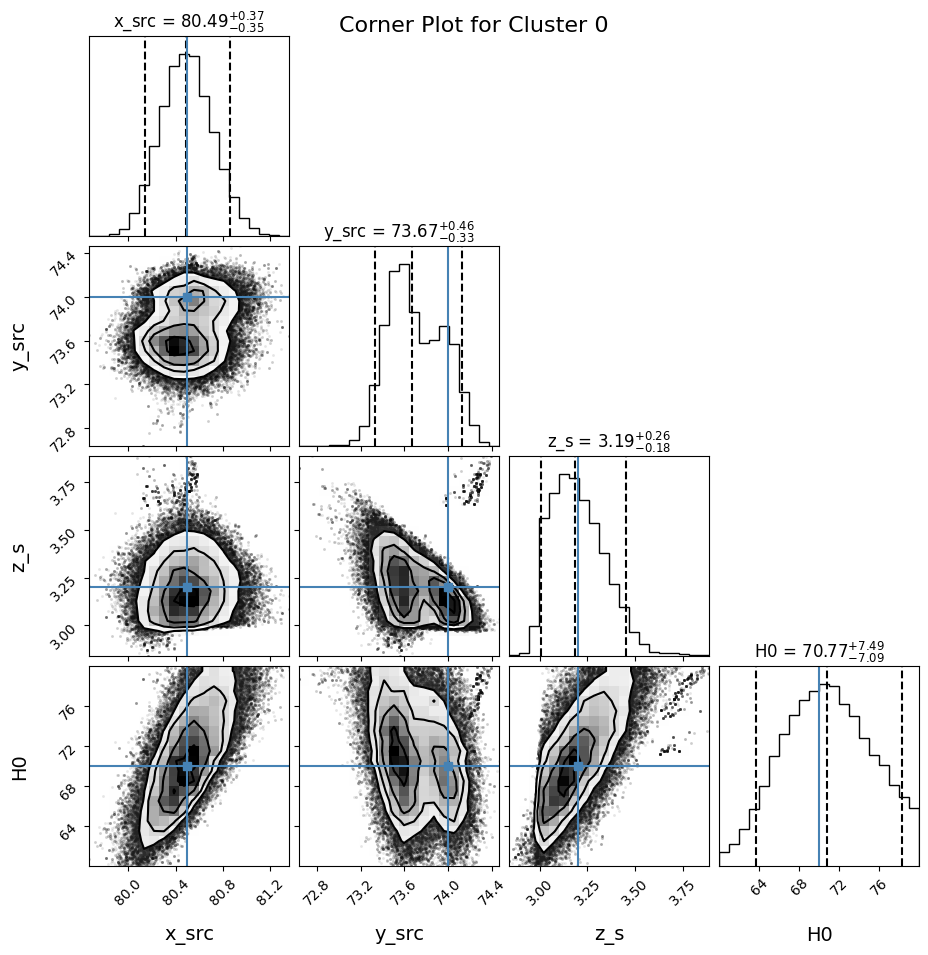

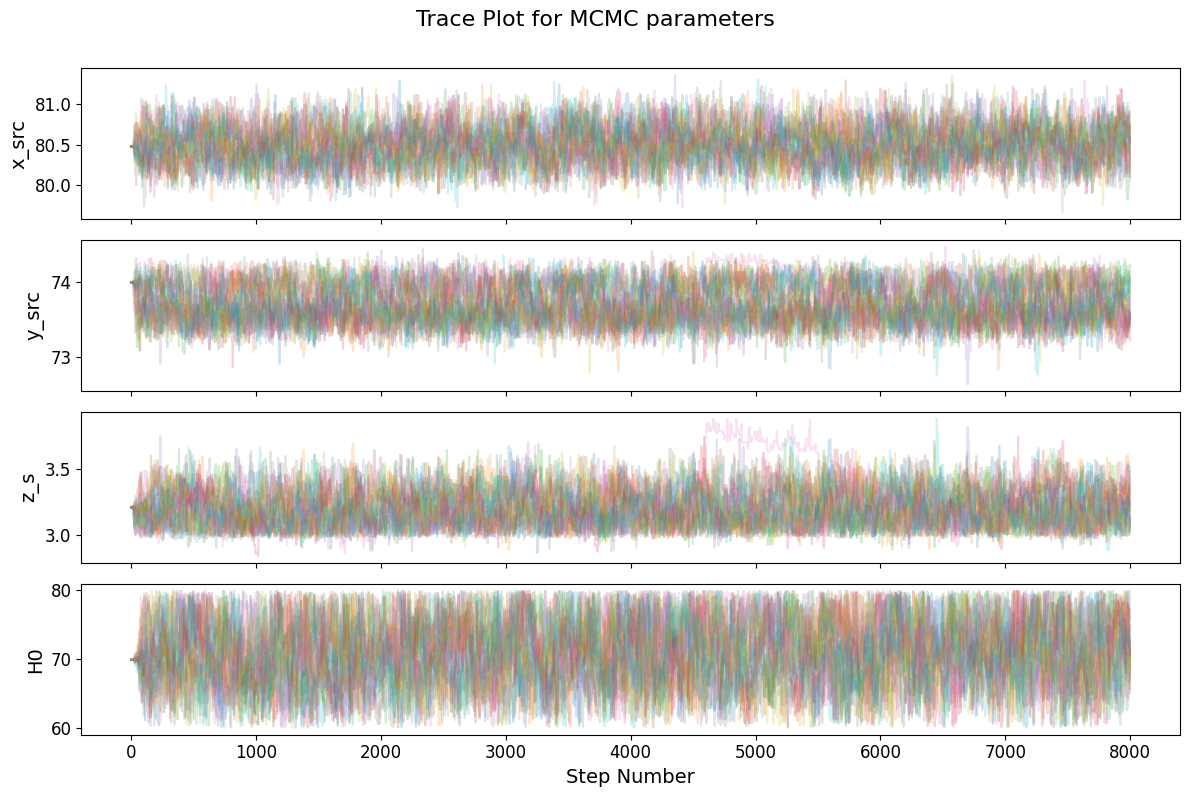

In [15]:
# Plot the corner and trace plots for the saved MCMC results
# Specify the directory where your results are saved
RESULTS_DIR = pathlib.Path("/home/dices/Research/GWlensing_Brian/oddratio/test_tidy_1")
# Specify the index of the cluster you want to plot
CLUSTER_INDEX_TO_PLOT = 0

# Construct the full path to the data file
data_file = os.path.join(RESULTS_DIR, f"cluster_{CLUSTER_INDEX_TO_PLOT}_posterior.npz")

# --- Step 1: Load the Saved Data ---
# Check if the file exists before trying to load it.
if not os.path.exists(data_file):
    print(f"Error: Data file not found at '{data_file}'")
    print("Please make sure you have run the main analysis script first.")
else:
    print(f"Loading data from {data_file}...")
    # np.load returns a dictionary-like object
    mcmc_data = np.load(data_file)

    # You can see what's inside the file by printing the keys
    print("Available data keys:", list(mcmc_data.keys()))

    # Extract the necessary arrays from the loaded data
    flat_chain = mcmc_data['flat_chain']
    full_chain = mcmc_data['chain']
    param_labels = mcmc_data['param_labels']
    truth_values = test_params['x_src'], test_params['y_src'], test_params['z_s'], test_params['H0']

    # --- Step 2: Create the Corner Plot ---
    # The corner plot is the best way to visualize the posterior distributions
    # and the correlations between parameters.

    print("\nGenerating corner plot...")
    
    # The corner.corner function takes the flattened (2D) chain of samples
    # and the labels for each parameter.
    fig_corner = corner.corner(
        flat_chain,
        labels=param_labels,
        quantiles=[0.05, 0.5, 0.95], # 90% intervals
        show_titles=True,
        truths=truth_values,  # If you have true values to plot
        label_kwargs={"fontsize": 14},  # Set axis label font size
        title_kwargs={"fontsize": 12},  # Set title font size
        verbose=False
    )

    fig_corner.suptitle(f"Corner Plot for Cluster {CLUSTER_INDEX_TO_PLOT}", fontsize=16)
    
    # Save the corner plot to a file
    corner_plot_path = os.path.join(RESULTS_DIR, f"cluster_{CLUSTER_INDEX_TO_PLOT}_corner_from_saved.png")
    fig_corner.savefig(corner_plot_path)
    print(f"-> Corner plot saved to {corner_plot_path}")
    

    # --- Step 3: Create the Trace Plot ---
    # A trace plot (or "time series plot") shows the value of each parameter at each
    # step of the MCMC chain for every walker. It is essential for diagnosing
    # convergence. You are looking for a stationary, "fuzzy caterpillar" look,
    # which indicates the walkers are well-mixed and exploring the same parameter space.

    print("\nGenerating trace plot...")
    
    n_steps, n_walkers, n_dim = full_chain.shape
    fig_trace, axes = plt.subplots(n_dim, figsize=(12, 2 * n_dim), sharex=True)
    steps = np.arange(n_steps)

    for i in range(n_dim):
        ax = axes[i]
        # The key command: This plots each of the n_walkers' paths as a separate line.
        ax.plot(steps, full_chain[:, :, i], alpha=0.2)
        ax.set_ylabel(param_labels[i], fontsize=14)
        ax.tick_params(axis='both', labelsize=12)

    axes[-1].set_xlabel("Step Number", fontsize = 14)
    axes[-1].tick_params(axis='both', labelsize=12)
    fig_trace.suptitle(f"Trace Plot for MCMC parameters", fontsize=16, y=0.99)
    fig_trace.tight_layout(rect=[0, 0, 1, 0.98])

    trace_plot_path = os.path.join(RESULTS_DIR, f"cluster_{CLUSTER_INDEX_TO_PLOT}_trace.png")
    fig_trace.savefig(trace_plot_path)
    print(f"-> Trace plot saved to {trace_plot_path}")

    plt.show()